In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import numpy as np
from tqdm import tqdm
from ste import STE

# Time-series dataset

In [2]:
# Define the country name.
COUNTRY = "Nigeria"

In [3]:
PATH_TO_DATA_FOLDER = "../Dataset time-series/output_data/" + COUNTRY + "/"

In [4]:
# Load the time-series dataset.
df = pd.read_csv(PATH_TO_DATA_FOLDER + "%s-day.csv" % COUNTRY, header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq

In [5]:
df.columns.get_level_values(1).unique()

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'Code', 'FCG <= 2', 'Fatalities', 'Lat', 'Lon', 'NDVI', 'NDVI Anomaly',
       'Population', 'Price cereals and tubers', 'Rainfalls (mm)', 'Ramadan',
       'rCSI >= 19'],
      dtype='object', name='Indicator')

In [6]:
# Consider only some indicators for the analysis with symbolic transfer entropy.
INDICATORS_TO_CONSIDER = ["FCG <= 2", "1 Month Anomaly Rainfalls (%)", "3 Months Anomaly Rainfalls (%)", "NDVI", "Price cereals and tubers", "Fatalities", "NDVI Anomaly", "rCSI >= 19", "Rainfalls (mm)"]
df = pd.concat([df.loc[:, (slice(None), feature)] for feature in INDICATORS_TO_CONSIDER], axis = 1).sort_index(axis = 1)
df

AdminStrata                       Adamawa                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2019-01-18                     100.259677                      93.037140   
2019-01-19                     100.244839                      93.977969   
2019-01-20                     100.230000                      95.031538   
2019-01-21                     100.215191                      96.061030   
2019-01-22                     100.200411                      97.066445   
...                                   ...                            ...   
2020-09-26                      77.297220                      89.440721   
2020-09-27                      78.097507                      89.420572   
2020-09-28                      78.983166                      89.407210   
2020-09-29                      79.954197                      89.400633   
2020-09-30                      81.010602                      89.400844   

AdminStrata                                               \
Indicator     FCG <= 2 Fatalities      NDVI NDVI Anomaly   
Datetime                                                   
2019-01-18   23.586938        0.0  0.334429    96.868029   
2019-01-19   22.755425        0.0  0.332291    96.927069   
2019-01-20   22.547817        0.0  0.330208    96.985875   
2019-01-21   23.758271        0.0  0.328135    97.044913   
2019-01-22   22.374279        0.0  0.326072    97.104183   
...                ...        ...       ...          ...   
2020-09-26   41.470788        0.0  0.649718    96.235517   
2020-09-27   45.390480        0.0  0.650146    96.312743   
2020-09-28   45.110420        0.0  0.650531    96.387221   
2020-09-29   45.623021        0.0  0.650872    96.458949   
2020-09-30   47.784233        0.0  0.651171    96.527928   

AdminStrata                                                     \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19   
Datetime                                                         
2019-01-18                  0.204482         0.0000  43.008741   
2019-01-19                  0.204677         0.0000  43.619385   
2019-01-20                  0.204873         0.0000  42.481559   
2019-01-21                  0.205068         0.0006  42.558962   
2019-01-22                  0.205264         0.0012  41.129399   
...                              ...            ...        ...   
2020-09-26                  0.842524       206.0412  16.702326   
2020-09-27                  0.841555       204.7794  16.707763   
2020-09-28                  0.840585       203.5176  19.095040   
2020-09-29                  0.839615       202.2558  20.885011   
2020-09-30                  0.838645       200.9940  21.148869   

AdminStrata                         Borno  ...             \
Indicator   1 Month Anomaly Rainfalls (%)  ... rCSI >= 19   
Datetime                                   ...              
2019-01-18                     100.000000  ...  35.259528   
2019-01-19                     100.000000  ...  34.719999   
2019-01-20                     100.000000  ...  34.653470   
2019-01-21                     100.000000  ...  34.362899   
2019-01-22                     100.000000  ...  36.355709   
...                                   ...  ...        ...   
2020-09-26                     114.770357  ...  11.992484   
2020-09-27                     115.029275  ...  13.156250   
2020-09-28                     115.303064  ...  14.377357   
2020-09-29                     115.591724  ...  14.936559   
2020-09-30                     115.895256  ...  14.129691   

AdminStrata                          Yobe                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2019-01-18                     100.000000                     143.249296   
2019-01-19

In [7]:
PROVINCES = df.columns.get_level_values(0).unique()
PROVINCES

Index(['Adamawa', 'Borno', 'Yobe'], dtype='object', name='AdminStrata')

In [8]:
PREDICTORS = df.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'FCG <= 2', 'Fatalities', 'NDVI', 'NDVI Anomaly',
       'Price cereals and tubers', 'Rainfalls (mm)', 'rCSI >= 19'],
      dtype='object', name='Indicator')

In [9]:
# Assign a color to each indicator.
#cols = plt.get_cmap("tab10")
cols = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
        (1.0, 0.4980392156862745, 0.054901960784313725),
        (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
        (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
        (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
        (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
        (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
        (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), 
        (1.0, 1.0, 0.2), 
        (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

colors = dict()
for i,indicator in enumerate(reversed(PREDICTORS)):
    #colors[indicator] = cols(i)
    colors[indicator] = cols[i]

# Importance of the indicators

In [10]:
df_feature_importance = df.drop("FCG <= 2", axis = 1, level = 1)

In [11]:
rows_ste = list()
rows_ste_rank = list()

def feature_importance(group):
    adminstrata = group.name
    rows = dict()
    for indicator in df_feature_importance.columns.get_level_values(1).unique():
        result = STE.calc_ste(group[adminstrata][indicator], df[adminstrata]["FCG <= 2"], m = 3, kx = 1, ky = 1, h = 1)
        rows[indicator] = result
    row = pd.Series(rows)
    row.name = adminstrata + " - FCG $\leq$ 2"
    rows_ste.append(row)
    rows_ste_rank.append(row.rank(method = "max", ascending = False))

tqdm.pandas()
df_feature_importance.groupby(level = 0, axis = 1).progress_apply(feature_importance);
T_fcs = pd.concat(rows_ste, axis = 1).transpose()
T_fcs_rank = pd.concat(rows_ste_rank, axis = 1).transpose()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s]


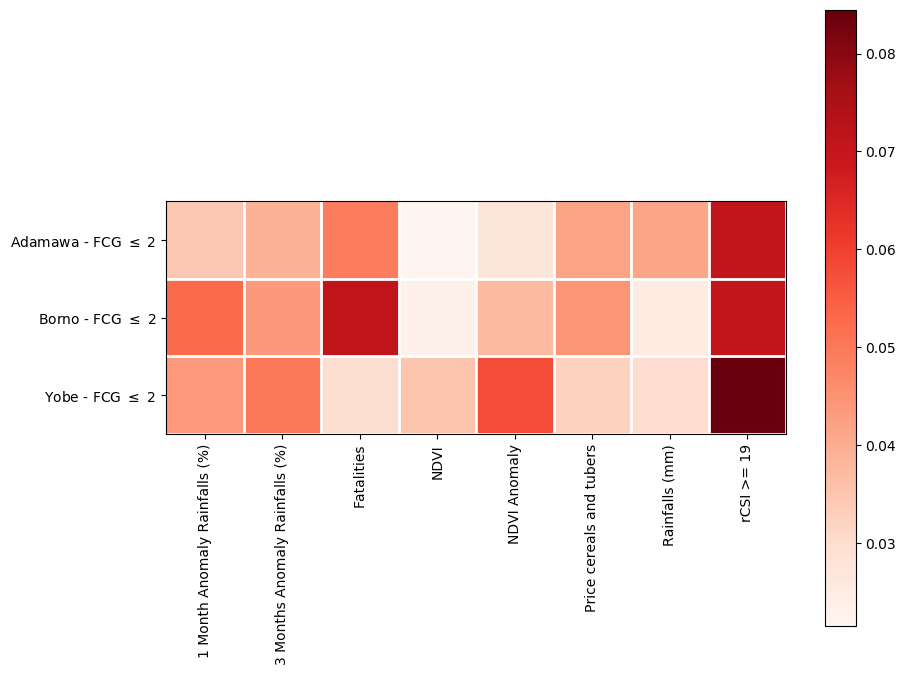

In [12]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(T_fcs.astype(float), cmap = "Reds")
    cbar = fig.colorbar(im, ax = ax)
    #clb = plt.colorbar()
    #cbar.set_label("STE", rotation = 270)

    ax.set_xticks(range(len(T_fcs.columns)))
    ax.set_yticks(range(len(T_fcs.index)))
    ax.set_xticklabels(T_fcs.columns, rotation = 90)
    ax.set_yticklabels(T_fcs.index)
    #ax.set_xlabel("Indicator")
    #ax.set_ylabel("AdminStrata")
    #ax.set_title("T - Influence different indicators for FCS")
    for i in range(T_fcs.shape[0]):
        ax.axhline(i + 0.5, color = "white", lw = 2)
    for i in range(T_fcs.shape[1]):
        ax.axvline(i + 0.5, color = "white", lw = 2)
        
    # Save the figure.
    fig.savefig("./output_images/Importance_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

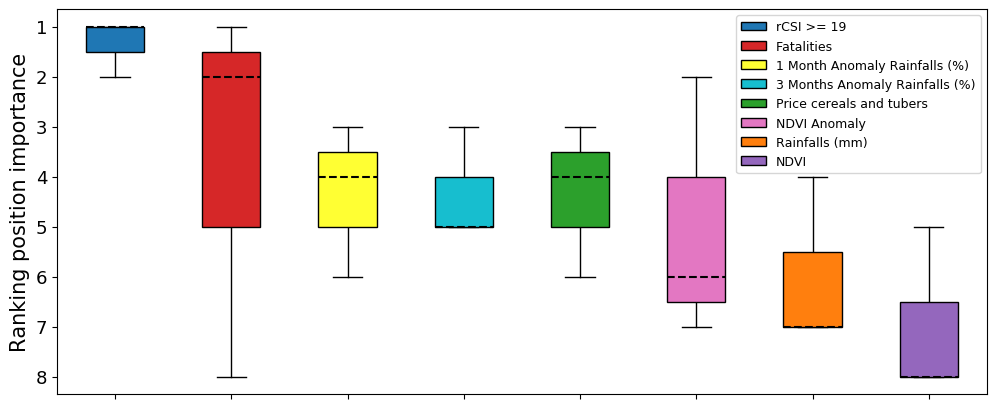

In [13]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (12, 5))
    T_fcs_rank = T_fcs_rank.astype(int)
    meds = T_fcs_rank.mean()
    meds.sort_values(ascending = True, inplace = True)
    T_fcs_rank_sort = T_fcs_rank[meds.index]
    #T_fcs_rank_sort = T_fcs_rank_sort[['rCSI', 'Fatalities', 'Rainfall (mm)', 'Rainfall Anomaly', 'NDVI Anomaly', 'Price cereals and tubers', 'Exchange rate']]
    #cm = plt.cm.get_cmap("tab20")
    #colors = [cm(val/len(T_fcs_rank_sort.columns)) for val in range(len(T_fcs_rank_sort.columns))]
    bplot = ax.boxplot(T_fcs_rank_sort.T, patch_artist = True, medianprops = {"linestyle": "--", "linewidth": 1.5, "color": "black"}) 
    # Fill with colors.
    legends = list()
    for patch, indicator in zip(bplot["boxes"], T_fcs_rank_sort.columns):
        patch.set_facecolor(colors[indicator])
        patch.set_label(indicator)
        legends.append(patch)
    
    ax.invert_yaxis()
    #ax.set_xlabel("Indicator")
    ax.set_ylabel("Ranking position importance", fontsize = 15)
    ax.tick_params(labelsize = 13)
    ax.set_xticklabels([""]*len(T_fcs_rank_sort.columns), rotation = 0, fontsize = 15)  

    ax.legend(legends, T_fcs_rank_sort.columns, loc = "upper right", prop = {"size": 9})
    
    # Save the figure.
    fig.savefig("./output_images/Ranking_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

# Lag importance

In [14]:
# Compute the entropy rate of the endogenous indicators (FCS indicator)..
lags = 15
def history_length_Y(serie):
    adminstrata = serie.name[0]
    y = list()
    for k in range(lags):
        result = STE.entropy_rate(serie, m = 3, k = k+1, h = 1)
        y.append(result)  
    return y  

tqdm.pandas()
df_results_Y = df.xs("FCG <= 2", axis = 1, level = 1, drop_level = False).progress_apply(history_length_Y)
df_results_Y.index = df_results_Y.index  + 1
df_results_Y.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


AdminStrata,Adamawa,Borno,Yobe
Indicator,FCG <= 2,FCG <= 2,FCG <= 2
1,1.370235,1.410020,1.328965
2,1.344388,1.376461,1.299987
3,1.274150,1.293021,1.188026
4,1.051641,1.036388,0.996741
5,0.788955,0.689624,0.745900


In [15]:
#df_results_Y = df_results_Y.diff().dropna()

In [16]:
def plot_quantiles(df, title = None, xaxis = None, yaxis = None, label = None):
    with plt.style.context("default"):
        # Define the subplot figure.
        fig, axs = plt.subplots(figsize = (15, 7))
        value_statistic = df.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = label, ax = axs, ms = 12, c = colors["FCG <= 2"])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors["FCG <= 2"], alpha = 0.3)
        # Set attributes of the plot.
        axs.set_title(title)
        axs.legend(loc = "best", prop = {"size": 15})
        axs.set_xlabel(xaxis, fontsize = 18)
        axs.set_ylabel(yaxis, fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(1, 16))
    return fig, axs

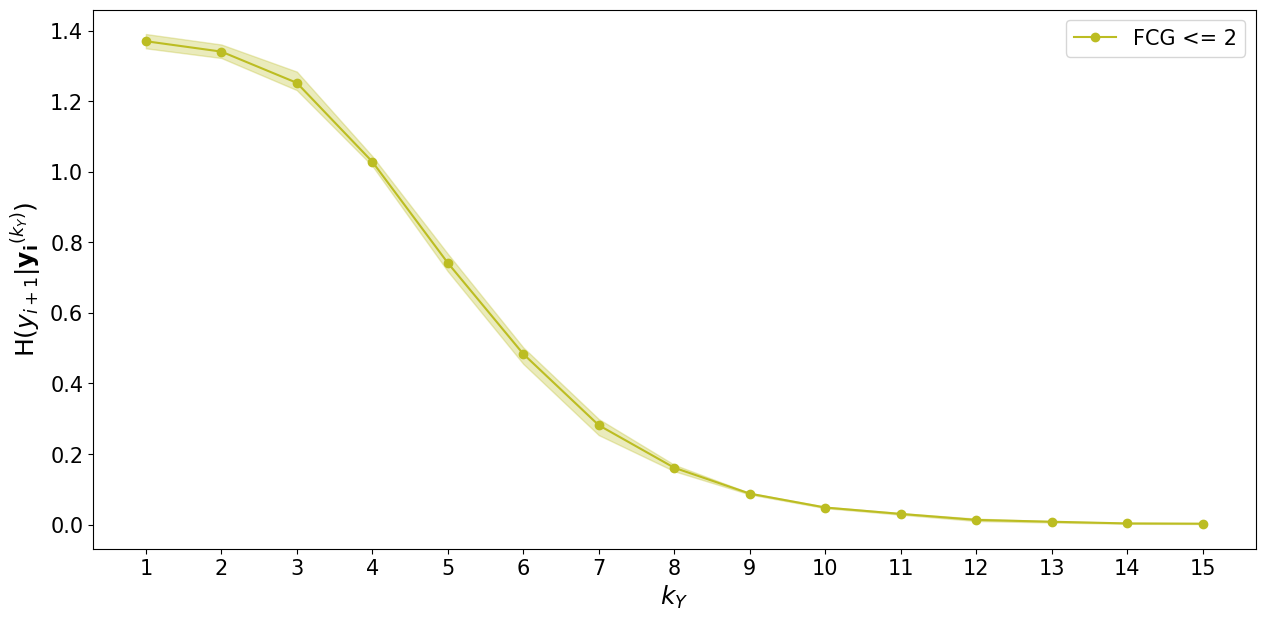

In [17]:
fig, axs = plot_quantiles(df_results_Y, xaxis = "$k_{Y}$", yaxis = "H($y_{i+1}|\mathbf{y_{i}}^{(k_Y)}$)", label = "FCG <= 2")

In [18]:
fig.savefig("./output_images/entropy_rate_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

In [19]:
# Select only the exogenous indicators.
df_no_fcs = df.drop(columns = ["FCG <= 2"], axis = 1, level = 1)
df_no_fcs.head()

AdminStrata                       Adamawa                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2019-01-18                     100.259677                      93.037140   
2019-01-19                     100.244839                      93.977969   
2019-01-20                     100.230000                      95.031538   
2019-01-21                     100.215191                      96.061030   
2019-01-22                     100.200411                      97.066445   

AdminStrata                                                             \
Indicator   Fatalities      NDVI NDVI Anomaly Price cereals and tubers   
Datetime                                                                 
2019-01-18         0.0  0.334429    96.868029                 0.204482   
2019-01-19         0.0  0.332291    96.927069                 0.204677   
2019-01-20         0.0  0.330208    96.985875                 0.204873   
2019-01-21         0.0  0.328135    97.044913                 0.205068   
2019-01-22         0.0  0.326072    97.104183                 0.205264   

AdminStrata                                                   Borno  \
Indicator   Rainfalls (mm) rCSI >= 19 1 Month Anomaly Rainfalls (%)   
Datetime                                                              
2019-01-18          0.0000  43.008741                         100.0   
2019-01-19          0.0000  43.619385                         100.0   
2019-01-20          0.0000  42.481559                         100.0   
2019-01-21          0.0006  42.558962                         100.0   
2019-01-22          0.0012  41.129399                         100.0   

AdminStrata                                 ...                            \
Indicator   3 Months Anomaly Rainfalls (%)  ... Rainfalls (mm) rCSI >= 19   
Datetime                                    ...                             
2019-01-18                      117.367238  ...            0.0  35.259528   
2019-01-19                      117.995892  ...            0.0  34.719999   
2019-01-20                      118.633264  ...            0.0  34.653470   
2019-01-21                      119.148946  ...            0.0  34.362899   
2019-01-22                      119.542937  ...            0.0  36.355709   

AdminStrata                          Yobe                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2019-01-18                          100.0                     143.249296   
2019-01-19                          100.0                     143.210813   
2019-01-20                          100.0                     143.053244   
2019-01-21                          100.0                     142.693166   
2019-01-22                          100.0                     142.130581   

AdminStrata                                                             \
Indicator   Fatalities      NDVI NDVI Anomaly Price cereals and tubers   
Datetime                                                                 
2019-01-18        66.0  0.232465    99.634913                 0.128119   
2019-01-19        66.0  0.231498    99.533540                 0.127451   
2019-01-20        70.0  0.230541    99.430884                 0.126782   
2019-01-21        70.0  0.229593    99.333907                 0.126114   
2019-01-22        70.0  0.228655    99.242609                 0.125446   

AdminStrata                            
Indicator   Rainfalls (mm) rCSI >= 19  
Datetime                               
2019-01-18             0.0  45.458462  
2019-01-19             0.0  45.499663  
2019-01-20             0.0  44.193480  
2019-01-21             0.0  45.048172  
2019-01-22             0.0  43.359342  

[5 rows x 24 columns]

In [20]:
lags = 15

In [21]:
def history_length_X(serie):
    adminstrata = serie.name[0]
    indicator = serie.name[1]
    y = list()
    for k in range(lags):
        result = STE.calc_ste(serie, df[adminstrata]["FCG <= 2"], m = 3, kx = k+1, ky = 1, h = 1)
        y.append(result)        
    return y  

tqdm.pandas()
df_results_X = df_no_fcs.progress_apply(history_length_X)
df_results_X.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:30<00:00,  1.29s/it]


AdminStrata                       Adamawa                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.034496                       0.038930   
1                                0.052503                       0.069320   
2                                0.091604                       0.101768   
3                                0.125984                       0.140117   
4                                0.154656                       0.159826   

AdminStrata                                                             \
Indicator   Fatalities      NDVI NDVI Anomaly Price cereals and tubers   
0             0.049123  0.021572     0.027642                 0.041926   
1             0.086831  0.037514     0.049669                 0.060009   
2             0.128203  0.048878     0.062185                 0.078902   
3             0.152773  0.062364     0.073472                 0.092579   
4             0.196361  0.076134     0.088508                 0.111596   

AdminStrata                                                   Borno  \
Indicator   Rainfalls (mm) rCSI >= 19 1 Month Anomaly Rainfalls (%)   
0                 0.041420   0.070828                      0.052857   
1                 0.065442   0.241134                      0.071103   
2                 0.097605   0.498261                      0.089209   
3                 0.118024   0.837970                      0.121886   
4                 0.137465   1.081531                      0.153440   

AdminStrata                                 ...                            \
Indicator   3 Months Anomaly Rainfalls (%)  ... Rainfalls (mm) rCSI >= 19   
0                                 0.043778  ...       0.024825   0.070720   
1                                 0.061420  ...       0.046821   0.236869   
2                                 0.080083  ...       0.058123   0.596616   
3                                 0.097376  ...       0.072835   0.879420   
4                                 0.118398  ...       0.084630   1.156098   

AdminStrata                          Yobe                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.043661                       0.050133   
1                                0.070814                       0.085136   
2                                0.107477                       0.110151   
3                                0.132541                       0.129489   
4                                0.157142                       0.158761   

AdminStrata                                                             \
Indicator   Fatalities      NDVI NDVI Anomaly Price cereals and tubers   
0             0.029669  0.035216     0.057784                 0.032252   
1             0.057711  0.041260     0.084195                 0.052207   
2             0.073201  0.045786     0.106229                 0.071280   
3             0.095046  0.054923     0.137329                 0.088469   
4             0.113595  0.060735     0.155697                 0.102895   

AdminStrata                            
Indicator   Rainfalls (mm) rCSI >= 19  
0                 0.029739   0.084488  
1                 0.034336   0.279897  
2                 0.040318   0.528896  
3                 0.046998   0.817006  
4                 0.052824   1.011277  

[5 rows x 24 columns]

In [22]:
df_results_X = df_results_X.diff().dropna()

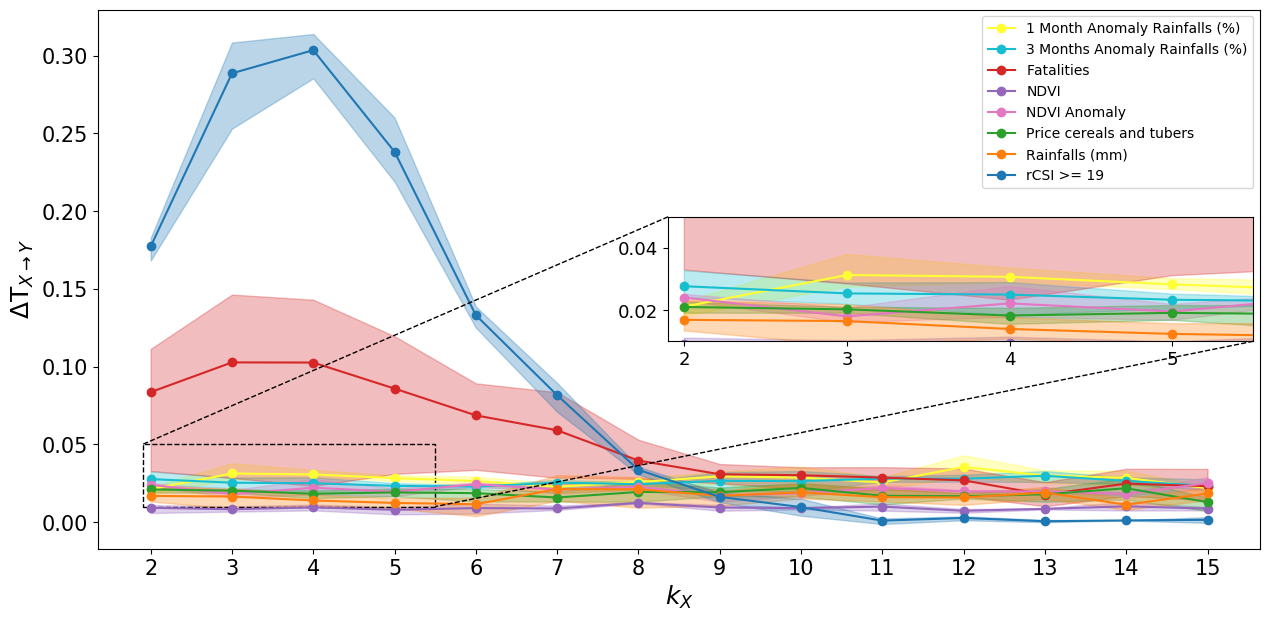

In [23]:
with plt.style.context("default"):
    # Define the subplot figure.
    fig, axs = plt.subplots(figsize = (15, 7))
    axins = zoomed_inset_axes(axs, 2., loc = "right")
    for i,indicator in enumerate(df_results_X.columns.get_level_values(1).unique()):
        subdf = df_results_X.xs(indicator, axis = 1, level = 1, drop_level = False)
        subdf.index = subdf.index + 1
        value_statistic = subdf.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axs, ms = 12, c = colors[indicator])
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axins, ms = 12, c = colors[indicator])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                           y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.set_xticks(np.arange(1, 6))
        axins.tick_params(labelsize = 13)
        # Set attributes of the plot.
        axs.legend(loc = "best", prop = {"size": 10})
        axs.set_xlabel("$k_{X}$", fontsize = 18)
        axs.set_ylabel(r'$\Delta$T$_{X \rightarrow Y}$', fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(2, 16))

    axins.set_xlim(1.9, 5.5)
    axins.set_ylim(0.01, 0.05)
    mark_inset(axs, axins, loc1 = 2, loc2 = 4, fc = "none", ec = "black", linestyle  = "--")
    # Save the figure.
    fig.savefig("./output_images/Lags_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)